This notebook searches for the ring positions in a series of images.

In [1]:
import time
start = time.time()
import os
import pylab as pl
import numpy as np
import numba
import scipy.ndimage as ndi
import hdf5plugin
import h5py
import pandas as pd
import fabio
from matplotlib.colors import LogNorm

%matplotlib notebook

In [2]:
csv_path = "eigerSpatial/detector_positions.csv"
df = pd.read_csv(csv_path)

In [3]:
for index, row in df.iterrows():
    if index != 0:
        scan = int(row["Scan number"])
        dest_path = os.path.join("eigerSpatial", str(scan) + ".par")
        with open("eigerSpatial/template.par", "r") as template_file:
            template_string = template_file.read()
        template_string = template_string.replace("ycent", str(row["Beam centre horiz in px"]))
        template_string = template_string.replace("zcent", str(row["Beam centre vertical in px"]))
        with open(dest_path, "w") as output_file:
            output_file.write(template_string)

In [4]:
scan_list = df["Scan number"].to_list()[1:]
scan_list_str = [str(int(x)) for x in scan_list]
scan_list_str = scan_list_str[-9:]

In [5]:
rawdata_dir = "/dls/i12/data/2022/cm31132-2/rawdata"

First, load the data with the powder diffraction patterns

In [6]:
for scan in scan_list_str:
    image_path = os.path.join(rawdata_dir, scan + "")
    cbf_path = os.path.join(rawdata_dir, scan + "-pilatus2M-files", "00001.cbf")
    frame = fabio.open(cbf_path).data
    print(scan,frame.shape, np.median(frame[:256,:256]))

109696 (1679, 1475) 149.0
109697 (1679, 1475) 169.0
109698 (1679, 1475) 188.0
109699 (1679, 1475) 194.0
109700 (1679, 1475) 214.0
109701 (1679, 1475) 234.0
109702 (1679, 1475) 237.0
109703 (1679, 1475) 255.0
109704 (1679, 1475) 255.0


<IPython.core.display.Javascript object>


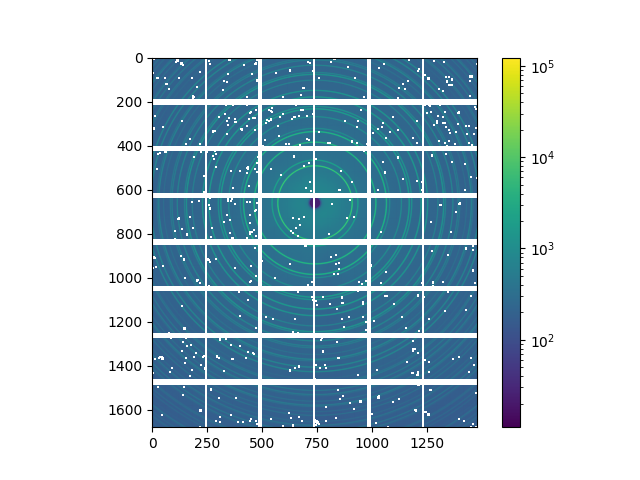

In [7]:
# load and display a demo image
img = fabio.open(os.path.join(rawdata_dir, "109700" + "-pilatus2M-files", "00001.cbf")).data
msk = img > 0

pl.figure()
pl.imshow( img * msk, norm = LogNorm() )
pl.colorbar()

Geometric description of the Eiger4M modules:

In [8]:
# Geometry of the modules
# fast = 0 - 486
# slow = 0 - 194
# 
# 3 modules wide (FAST)
# 8 modules high (SLOW)
# FAST IS HORIZONTAL
# SLOW IS VERTICAL
def mod_start(s,f):
    """ s, f are the module coordinates in the range 0-4
    s/f refer to fast/slow pixel directions to use in C style
    array indexing data[s][f].
    returns the first pixel in the corner of the module
    """
    ssize = 194
    fsize = 486
    soffset = [0, 18, 2*18, 3*18, 4*18, 5*18, 6*18, 7*18]
    foffset = [0, 9, 2*9]
    fstart = fsize*f + foffset[f]
    sstart = ssize*s + soffset[s]
    return sstart, fstart

def module(image, s, f):
    """ image is a full image.
    s,f selects one of the  modules 
    """
    ssize = 194
    fsize = 486
    soffset = [0, 18, 2*18, 3*18, 4*18, 5*18, 6*18, 7*18]
    foffset = [0, 9, 2*9]
    fstart = fsize*f + foffset[f]
    sstart = ssize*s + soffset[s]
    roi = image[ sstart : sstart + ssize,
                 fstart : fstart + fsize]
    return roi

<IPython.core.display.Javascript object>


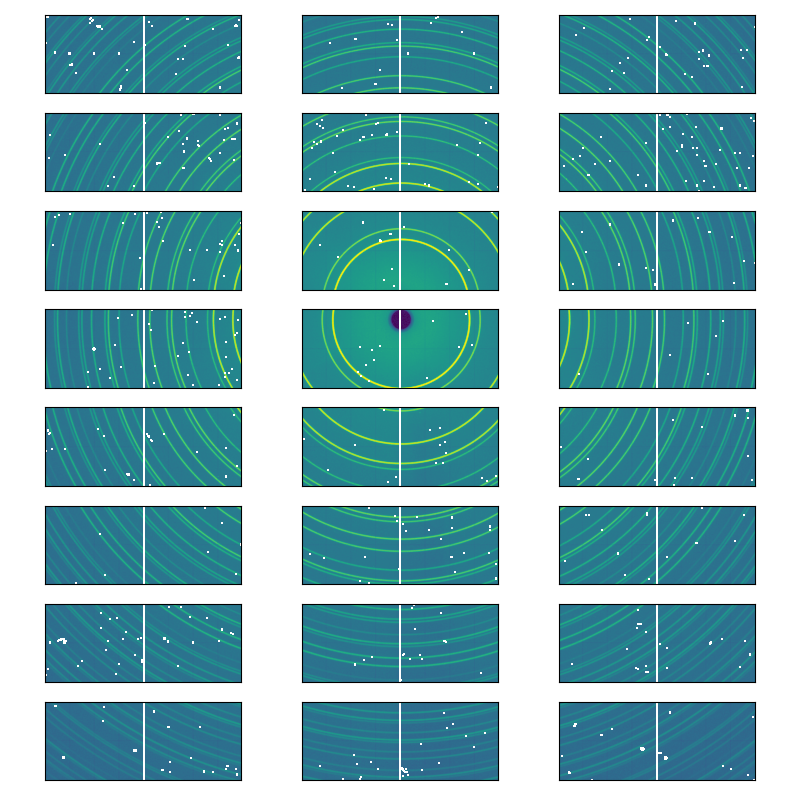

In [9]:
# check we have the module geometry
fig, ax = pl.subplots( 8, 3, figsize=(8,8))
for s in range(8):
    for f in range(3):
        ax[s][f].imshow( module(img,s,f), norm=pl.matplotlib.colors.LogNorm(20,10000))
        ax[s][f].set(xticks=[], yticks=[])
fig.tight_layout()

/dls/science/users/username/Software/custom_conda_envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


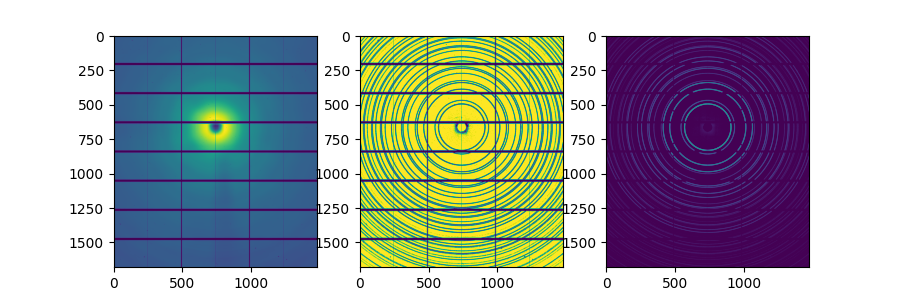

<IPython.core.display.Javascript object>


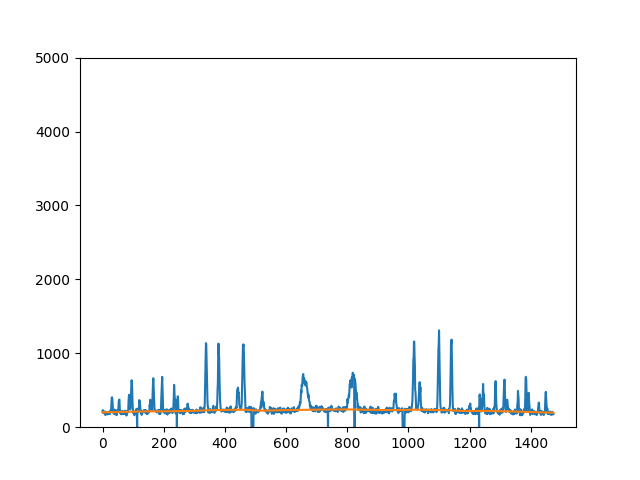

(0.0, 5000.0)

In [10]:
# Estimate what is peak and background
def guessbg( img, nsigma = 5, size = 64, cycles = 5, saturated=pow(2,20)):
    msk = ( img < saturated ) & ( img > 0 )
    sigdata = np.sqrt(img) # approximation
    for i in range(3):
        cimg  = img.astype(np.float32) * msk
        sumpx = ndi.uniform_filter( cimg, size=size, mode='constant', cval=0 )
        sum1  = ndi.uniform_filter( msk.astype(np.float32),  size=size, mode='constant' )
        avg   = sumpx / np.where(sum1>0, sum1, 1)
        pks   = cimg > avg + sigdata * nsigma
        msk   = msk & (~pks)
    cimg = img.astype(np.float32) * msk
    sumpx = ndi.uniform_filter( cimg, size=size, mode='constant' )
    sum1  = ndi.uniform_filter( msk.astype(np.float32), size=size, mode='constant' )
    avg   = sumpx / np.where(sum1>0, sum1, 1)
    return avg, msk


bkgimage, bgmask = guessbg( img )
msk = np.logical_and(img > 0, img < 1e5)
bim = (img.astype(np.float32) - bkgimage)*msk

fig, ax = pl.subplots(1, 3, figsize=(9,3))
ax[0].imshow( bkgimage * msk )
ax[1].imshow( bgmask )
ax[2].imshow( bim + 1000, norm=LogNorm(vmin=1000) )
pl.figure()
pl.plot((img*msk)[10])
pl.plot(bkgimage[10])
pl.ylim(0,5000)

We will go through the modules one by one and look for peaks in each row and column of pixels. 

In [11]:
@numba.njit
def fitpks(signal, msk, mbg, bgv, minpk=2, maxpk=40, label = 0):
    """ 
    signal is a 2D array with peaks in it
    msk defines which pixels can be used (skip values > 1e9)
    mbg labels pixels as being part of peak or background
    bgv estimate of the background level
    minpk = 4  : number of pixels needed to define a peak
    maxpk = 35 : max number of pixels allowed in a peak
    label = int : to track where peaks came from
    
    condition is finding bg->pk->bg with (maxpk > s1 > minpk) 
    
    The +1 is due to the clipping before calling this function (???)
    
    returns a list of peaks, each peak is:
      (slow_center, fast_center, sum_signal, npixels, fixed_index, module_label)
    """
    pks=[]
    for i in range(signal.shape[0]):
        s1 = 0       # sum of pixels in peak
        sI = 0       # sum of intensity in peak
        sfI = 0      # sum of intensity * fast pixel co-ordindate
        gotbg = False
        for j in range(signal.shape[1]):
            if msk[i,j] == 1: # pixels can be used
                if mbg[i,j] == 1: # in background
                    gotbg = True
                    # save the last peak if there was one
                    if s1 > minpk and s1 < maxpk:
                        # centre of mass position is sfI/sI
                        pks.append( (i , float(sfI) / sI , sI, s1, 0, label ) )
                    # ... and reset peak counters
                    s1 = 0; sI = 0; sfI = 0
                else: # inside a peak
                    if gotbg:
                        s1  += 1; 
                        sI  += (signal[i,j]-bgv)
                        sfI += (signal[i,j]-bgv)*j
            else: # just saw mask, so reset sums
                s1  = 0
                sfI = 0
                sI  = 0
                gotbg = False
    # Now repeat the same code but for the transposed array
    for j in range(signal.shape[1]):
        s1 = 0
        sI = 0
        ssI = 0
        gotbg = False
        for i in range(signal.shape[0]):
            if msk[i,j] == 1: # pixels can be used
                if mbg[i,j] == 1: # in background
                    gotbg = True
                    if s1 >= minpk and s1 < maxpk:
                        pks.append( ( float(ssI) / sI , j , sI, s1, 1, label))
                    s1 = 0; sI = 0; ssI = 0
                else: # in peak
                    if gotbg:
                        s1  += 1
                        sI  += (signal[i,j]-bgv) 
                        ssI += (signal[i,j]-bgv)*i
            else:
                s1 = 0
                ssI = 0
                sI = 0
    if len(pks) == 0:
        return None
    else:
        return np.array(pks)

def process_chip(chip, modu=0, nsigma=3):
    """ chip = 2D array
    
    
    modu = module label
    
    Defines a mask
    Thresholds to determine what is peak versus background
    Runs fitpks to get peak positions
    return peak positions
    """
    roi = chip.copy()
    msk = roi > 0    # Dectris mask
    roi = roi * msk    # zeros out the bad pixels
    sel = msk          # select all pixels as background
    for i in range(5):
        m = roi[sel].mean()   # mean background value
        s = roi[sel].std()    # sigma - clipping method (from pyFAI / vamvakeros / et al)
        sel = (roi < m+s*nsigma) & msk
    bg1 = roi[sel].mean()    
    mbg = sel
    pks = fitpks( roi, msk, mbg, bg1, minpk=2, label=modu )
    return pks, mbg

<IPython.core.display.Javascript object>


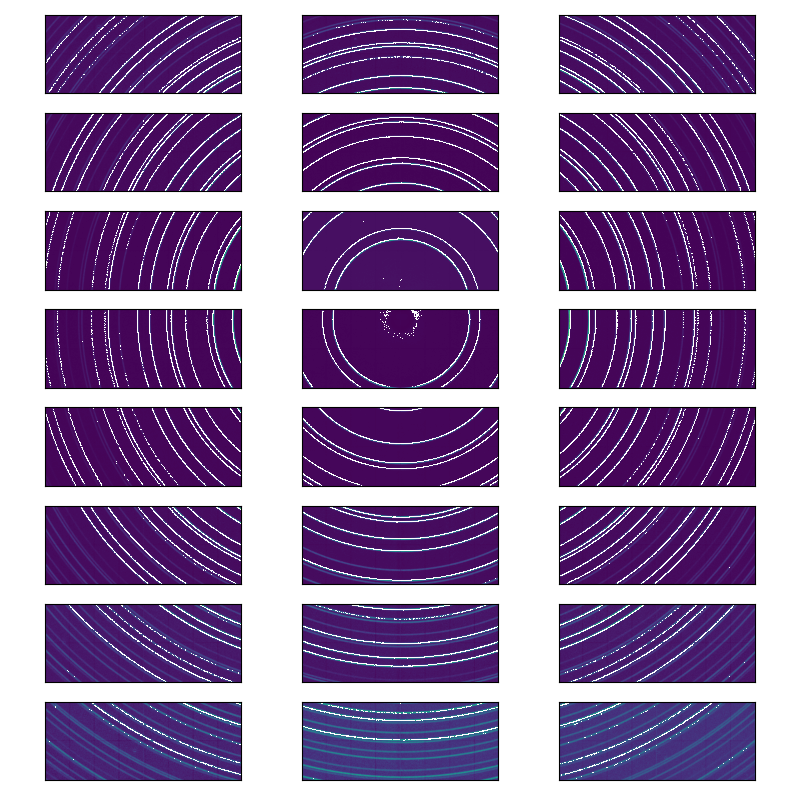

In [12]:
# test with plot
fig, ax = pl.subplots(8, 3, figsize=(8,8))
for i in range(8):
    for j in range(3):
        roi = module(bim,i,j)
        pks, mbg = process_chip(roi, modu=i*3+j)
        ax[i][j].imshow( roi )
        ax[i][j].plot( pks[:,1], pks[:,0], "w," )
        ax[i][j].set(xticks=[], yticks=[])
fig.tight_layout()

In [13]:
def search_image(im):
    """Loops over the 8x3 modules"""
    allpks = []
    bkgimage, bgmask = guessbg( im )
    msk = im > 0
    bim = (im.astype(np.float32) - bkgimage)*msk
    for i in range(8):
        for j in range(3):
            cs = module(bim,i,j)
            pks, mbg = process_chip(cs, modu=i*3+j)
            io, jo = mod_start(i,j)
            if pks is not None:
                pks[:,0] += io
                pks[:,1] += jo
                allpks.append(pks)
    ap = np.concatenate(allpks,axis=0).T
    return ap

In [14]:
%%time
p = search_image(img)
print(p.shape)

/dls/science/users/username/Software/custom_conda_envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


(6, 53900)
CPU times: user 452 ms, sys: 52.5 ms, total: 505 ms
Wall time: 460 ms


/dls/science/users/username/Software/custom_conda_envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


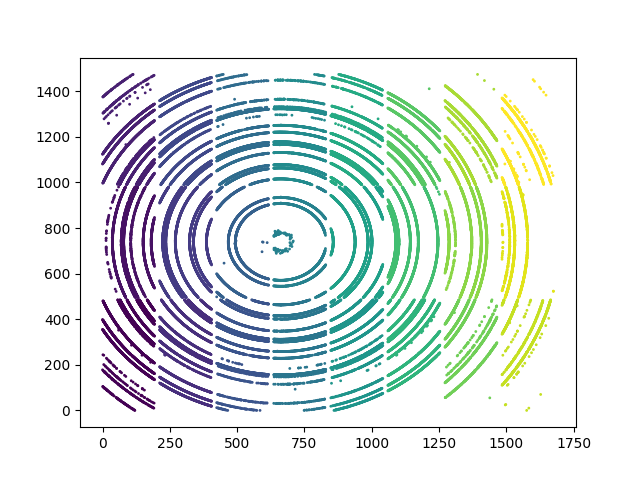

(6, 53900)


In [15]:
sc,fc,sI,s1,sf,m = p = search_image(img)
pl.figure()
pl.scatter(sc,fc,c=m,s=1)
print(p.shape)

In [16]:
def saveflt(outname, pks):
    """Save the peaks into ImageD11 columnfile format (text file)"""
    with open(outname,"w") as f:
        f.write("#  sc  fc  omega  Number_of_pixels  sum_intensity  direction  module  s_raw  f_raw\n")
        for sc,fc,I,s1,sf,m in pks.T:
            f.write("%.3f %.3f 0.0 %d %.1f %d %d %.3f %.3f\n"%(sc,fc,s1,I,sf,m,sc,fc))
saveflt("demo.flt", p) 

In [17]:
!pwd
if not os.path.exists("eigerSpatial"):
    os.mkdir("eigerSpatial")

/home/username/Code/EigerPowderSpatial


In [18]:
for scan in scan_list_str:
    image_path = os.path.join(rawdata_dir, scan + "")
    cbf_path = os.path.join(rawdata_dir, scan + "-pilatus2M-files", "00001.cbf")
    frms = fabio.open(cbf_path).data
    print(scan,frms.shape,np.median(frms[:256,:256]))
    im = frms
    pks = search_image( im )
    outname = "eigerSpatial/%s.flt"%(scan)
    saveflt(outname, pks) 

109696 (1679, 1475) 149.0


/dls/science/users/username/Software/custom_conda_envs/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


109697 (1679, 1475) 169.0
109698 (1679, 1475) 188.0
109699 (1679, 1475) 194.0
109700 (1679, 1475) 214.0
109701 (1679, 1475) 234.0
109702 (1679, 1475) 237.0
109703 (1679, 1475) 255.0
109704 (1679, 1475) 255.0


<IPython.core.display.Javascript object>


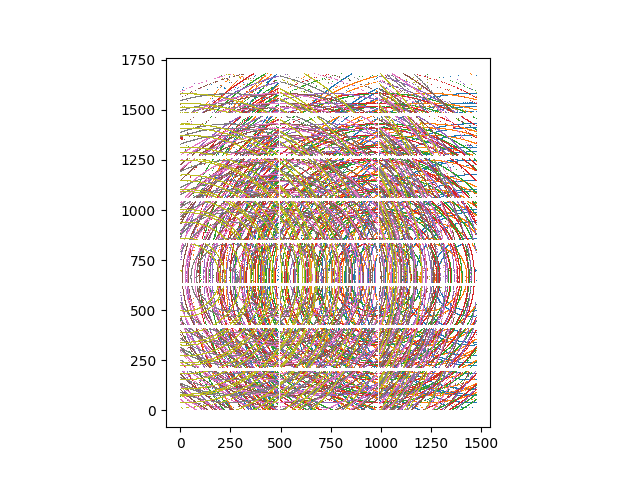

In [19]:
from ImageD11.columnfile import columnfile
import glob
pl.figure()
for fname in sorted(glob.glob("eigerSpatial/*.flt")):
    c = columnfile( fname )
    pl.plot(c.fc,c.sc,',')
pl.gca().set_aspect('equal')

In [20]:
print("Output created on %s"%(time.ctime()))
print("Total runtime %.3f /s"%(time.time()-start))

Output created on Tue Apr 19 19:02:39 2022
Total runtime 14.409 /s
